# GCNN Model - For COVID-19 

We first indroduce the GCNN model here. 

We have a zip code graph $G(V, E, A)$, $\left|V\right|=N$. $A\in R^{N\times N}$ is the adjacency matrix, so that it measures the similarity between zip codes, and it can be constructed from spatial distance, or we can consider it's unknown and learn the parameters during the training. 

The GCNN model has two components: graph convolutional part, and layer-wise calculation part. The convolutional part is based on the spectral convolution on graph such that we can embedding our data into convolved signal matrix using $z = D^{-1/2}\hat{A}D^{-1/2}X\theta$, which is called first-order polynomial convolution. Where 

* $X$ is $N\times p$ matrix that p is the number of features, 
* $\hat{A}=A + I_{N}$ is the sum of the adjacency matrix of undirected graph $A$ and identity matrix $I_N$, 
* $D\in R^{N\times N}$ is a siagonal degree matrix with $D_{jj}=\sum_j \hat{A}_{ij}$, 
* the $\theta \in R^{C\times F}$ is a matrix of filter parameters, 
* output $Z \in R^{N\times F}$ is the convolved signal matrix. 

In our basic GCNN model, we used the the previous five days case number as features, so $P = 5$. The intuition behind is that it combines the signal at the central vertex with signals at vertices that a maximum of number of steps away. The layer-wise calculation part is a neural network structure such that it maps the $Z$ to $H$, where $H$ could be $R^{N\times 1\ldots t}$, where $1\ldots t$ represents the how many subsequent time we would like our model to predict. The layer-wise part can have variants, such as using feedforward, or using RNN. 

In the obove artictitecture we used the the feed forward structure. We have a $3153$ zip codes, $58$ days data (Between 3-23-2020 to 5-23-2020), and $48$ days will be used as training, $5$ used as validation, $5$ as out of sample prediction/testing. Here we predict 1 day after case. We use dropout with probability in training to take care of overfitting.  

Below cell is our code which implemented the GCNN, following with the out of sample prediction results, for "Confirmed" and "Deaths" Cases, respectively. 


In [6]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import logging
import time
import traceback
import collections
import pandas as pd 
# import geopandas as gpd
# import folium
import numpy as np 
import itertools
# from folium.plugins import HeatMap
import tensorflow as tf
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import scipy.sparse as sp
import pickle
from datetime import timedelta
from scipy.stats.stats import pearsonr
import datetime 
import json
from scipy.stats.stats import pearsonr
from tensorflow.python.framework import ops
tf.compat.v1.disable_eager_execution()

class cov19():
    def __init__(self,param):
        self.param=param
        code_dir = self.param['code_dir']
        self.output_dir = os.path.join(code_dir, '../output')
        self.data_dir = os.path.join(code_dir, '../data')
        
        f1 = os.path.join(self.data_dir, 'us_daily_processed.csv')
        print(os.path.isfile(f1))
        if not os.path.isfile(f1):
            inputfile = self.input_processing()
            self.dataparepare(inputfile)
        
        outfolder = os.path.join(self.output_dir,"gcnn")
        if not os.path.exists(outfolder):
            os.makedirs(outfolder)
        response = self.param['response']
        
        f2 = os.path.join(outfolder, 'us_daily_zip_{}'.format(response))
        
        if not os.path.isfile(f2):
            self.create_learning_data()
        # self.geo_map()
        # self.geosimilarity()
    
    def input_processing(self):
        datafolder="../data/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports"
        thisdir = os.getcwd()
        csv_files = []
        for root, dirs, files in os.walk(datafolder):
            for file in files:
                if file.endswith('.csv'):
                    csv_files.append(os.path.join(datafolder,file))
        return csv_files

    def dataparepare(self,inputfile):
        dates = [os.path.split(file)[1][:-4] for file in inputfile]
        f = open(inputfile[-1],'r')
        keys=f.readline().strip().split(",")[:-1]
        all_values = {}
        all_values['date'] = []
        for i in keys:
            all_values[i] = []
        
        for i,(file,date) in enumerate(zip(inputfile,dates)):
            f = open(file,'r')
            header=f.readline().strip().split(",")
            oldids = ['Province/State','Country/Region', 'Last Update','Latitude','Longitude']
            newids = ['Province_State','Country_Region', 'Last_Update','Lat','Long_']
            for (k,l) in zip(oldids,newids):
                if k in header:
                    idx=header.index(k)
                    header[idx] = l
            
            
            for line in f:
                line_value = line.strip().split(",")
                keyvalue = dict(zip(header, line_value)) 
                keyvalue['date'] = date
                if keyvalue['Country_Region']=='US':
                    for key in all_values.keys():
                        if key in keyvalue:
                            all_values[key].append(keyvalue[key])
                        else:
                            all_values[key].append('')
                            
        
        usdaily = pd.DataFrame(all_values) 
        usdaily.sort_values('date',inplace=True,ignore_index=True)
        usdaily.to_csv(os.path.join(self.data_dir, 'us_daily_processed.csv'))
        # print(usdaily.head(100))   
        # 
    def geo_map(self):
        outfolder = os.path.join(self.output,'geomap')
        if not os.path.exists(outfolder):
            os.makedirs(outfolder)
        congr_districts = gpd.read_file('zip://'+'../data/cb_2015_us_cd114_20m.zip')

        # Set datum and projection info for census.gov 2015 Tiger data
        congr_districts.crs = {'datum': 'NAD83', 'ellps': 'GRS80', 'proj':'longlat', 'no_defs':True}

        # Filter out all but the district of interest
        district23 = congr_districts[ congr_districts.GEOID == '3623' ]  # 36 = NY, 23 = District


        df = pd.read_csv(os.path.join(self.data_dir, 'us_daily_processed.csv'))
        
        dates = ['03-22-2020','04-07-2020','04-22-2020','05-08-2020','05-19-2020']
        values = ['Confirmed','Deaths','Active']
        for (date, value) in list(itertools.product(dates, values)):
            sub_data = df.loc[df['date']==date]
            sub_data = sub_data[sub_data[['Lat',value,'Long_']].notnull().all(axis=1)]
            sub_data[value] = df[value].astype(float)
            max_amount=float(sub_data[value].max())
            hmap = folium.Map(location=[42.5, -100], zoom_start=4, )
            hm_wide = HeatMap( list(zip(sub_data.Lat.values, sub_data.Long_.values, sub_data[value].values)),
                    min_opacity=0.2,
                    max_val=max_amount,
                    radius=17, blur=15, 
                    max_zoom=1, 
                    )
            hmap.add_child(hm_wide)
            hmap.save(os.path.join(outfolder, 'heatmap_{}_{}.html'.format(date,value)))

        # dates = ['03-22-2020']
        # for date in dates: 
        #     sub_data = df.loc[df['date']==date]
        #     sub_data = df.loc[:,['Admin2','Admin2']]
    def pick_save(self, name, obj):
        with open(name, 'wb') as output:
            pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)   
    def pick_load(self, name):
        with open(name, 'rb') as input:
            obj = pickle.load(input)
        return obj 

    def create_temper_data(self, ids):
        outfolder = os.path.join(self.output_dir,'gcnn')
        if not os.path.exists(outfolder):
            os.makedirs(outfolder)
        
        
        zips = ids['zip']
        n = len(zips)
        uniqid = np.arange(len(zips))
        years = np.full((n,),2020)
        month_start = np.full((n,),3)
        day_start = np.full((n,),23)
        month_end = np.full((n,),5)
        day_end = np.full((n,),24)
        filename = os.path.join(self.data_dir,'dailyweather/get-weather-data/zip2wd/covid-input.csv')
        if not os.path.isfile(filename):
            csvfile = open(filename, 'w')
            csvwriter = csv.writer(csvfile, dialect='excel', delimiter=',',
                                    quotechar='"', quoting=csv.QUOTE_MINIMAL)
            headers = ['uniqid','zip','from.year','from.month',\
                'from.day','to.year','to.month','to.day']
            csvwriter.writerow(headers)
            for value in zip(uniqid,zips,years,month_start,day_start,years,month_end,day_end):
                csvwriter.writerow(value)
            csvfile.close()
        
        f2 = os.path.join(self.data_dir,'dailyweather/get-weather-data/zip2wd/output.csv')
        if not os.path.isfile(f2):
            print("please create temperature data from database")
        else: 
            df2 = pd.read_csv(f2, header = 0)
            df2['date'] =pd.to_datetime(df2[['year', 'month', 'day']])
            df2['zip'] = df2['zip'].apply(lambda x: '{0:0>5}'.format(x))
            print(df2.columns)
            ## first filling missing within every zipcode
            for col in ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']:
                df2[col] = df2.groupby(['zip'])[col].ffill()
                df2[col] = df2.groupby(['zip'])[col].bfill()
            ## then sort by date, zipcode
            
            df2 = df2.sort_values(['date','zip'])
            
            for col in ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']:
                df2[col] = df2.groupby(['date'])[col].ffill()
                df2[col] = df2.groupby(['date'])[col].bfill()
            
            df2 = df2.sort_values(['zip','date'])
            # f4 = os.path.join(self.data_dir,'dailyweather/get-weather-data/zip2wd/zz.csv')
            # df2.to_csv(f4)
            
            values = []
            columns = ['TMAX', 'TMIN']
            for col in columns:
                df_ = df2.pivot_table(index='date', columns='zip', values='TMAX', fill_value=0)
                value = df_.values 
                values.append(value)
            # df3 = pd.crosstab(df2.date, df2.zip)
            stack_values = np.stack(values, axis=2)
            
        return (stack_values,columns)
            # f4 = os.path.join(self.data_dir,'dailyweather/get-weather-data/zip2wd/zz.csv')
            # df3.to_csv(f4)

       

    
    def create_learning_data(self):
        outfolder = os.path.join(self.output_dir,"gcnn")
        if not os.path.exists(outfolder):
            os.makedirs(outfolder)
        response = self.param['response']
        
        filename = os.path.join(outfolder, 'us_daily_zip_{}'.format(response))
        
        
        
        df = pd.read_csv(os.path.join(self.data_dir, 'us_daily_processed.csv'))
        date = '03-23-2020'
        idx = df[df['date']==date].index[0]
        sub_data = df.iloc[idx:,]
        sub_data = sub_data[sub_data[['FIPS','Lat','Long_','Confirmed','Deaths','Recovered','Active']].notnull().all(axis=1)]
        sub_data['FIPS'] = sub_data['FIPS'].astype(int)
        sub_data['FIPS'] = sub_data['FIPS'].astype(str)
        sub_data['FIPS'] = sub_data['FIPS'].apply(lambda x: x.zfill(5))
        ## unique id of FIPS
        gpy = sub_data.groupby('FIPS').first()
        ids = {'zip':gpy.index.tolist(), 'city': gpy['Admin2'].values, \
            'state':gpy['Province_State'].values, \
                'lat': gpy['Lat'].values, 'long': gpy['Long_'].values}
        
        zips = np.unique(sub_data['FIPS'].values)
        dates = np.unique(sub_data['date'].values)
         
        # infors = self.pick_load(os.path.join(outfolder, 'us_daily_zip_{}'.format('Confirmed')))
        
        

        ## create confirmed cases,or deaths data
        
        daily_data = np.zeros((dates.shape[0],zips.shape[0]))
        for index, row in sub_data.iterrows():
            date = row['date']
            zip = row['FIPS']
            value = row[response]
            rowidx = np.where(dates == date)[0][0]
            colidx = np.where(zips==zip)[0][0]
            daily_data[rowidx,colidx]=value

        df_matrix = pd.DataFrame(data=daily_data,index=dates,columns=zips)  
        
        # df_matrix.to_csv(os.path.join(outfolder, 'us_daily_zip.csv'))

        ## create temperature data
        (df_temper, columns) = self.create_temper_data(ids)
        infors = [ids,dates,df_matrix]
        # infors = self.pick_load(os.path.join(outfolder, 'us_daily_zip_{}'.format('Confirmed')))
        
        infors.append(df_temper)
        infors.append(columns)

        self.pick_save(filename, infors)

    def geosimilarity(self):
        df = pd.read_csv(os.path.join(self.data_dir, 'us_daily_processed.csv'))
        columns = df.columns
        max_lat,min_lat = np.max(df['Lat'].values),np.min(df['Lat'].values)
        max_long,min_long = np.max(df['Long_'].values),np.min(df['Long_'].values)

def pick_save(name, obj):
        with open(name, 'wb') as output:
            pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)   
def pick_load(name):
    with open(name, 'rb') as input:
        obj = pickle.load(input)
    return obj 
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    #adj[np.isnan(adj)] = 0.
    adj = tf.abs(adj)
    rowsum = tf.reduce_sum(adj, 1)# sum of each row

    d_inv_sqrt = tf.pow(rowsum, -0.5)
   
    #d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    
    d_mat_inv_sqrt = tf.linalg.diag(d_inv_sqrt)

    return tf.matmul(tf.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)

class StandardScaler:
    """
    Standard the input
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean   
    
    
class Modeler():
    def __init__(self, param):
        self.param = param
        
    # Create model
    def gcn(self, signal_in, weights_hidden, weights_A, biases, hidden_num, node_num, horizon):
        
        signal_in = tf.transpose(signal_in, [1, 0, 2]) # node_num, ?batch, feature_in
        feature_len = signal_in.shape[2] # feature vector length at the node of the input graph

        i = 0
        while i < hidden_num:
            signal_in = tf.reshape(signal_in, [node_num, -1]) # node_num, batch*feature_in
            Adj = 0.5*(weights_A['A'+str(i)] + tf.transpose(weights_A['A'+str(i)])) 
            Adj = normalize_adj(Adj)
            Z = tf.matmul(Adj, signal_in) # node_num, batch*feature_in 
            Z = tf.reshape(Z, [-1, int(feature_len)]) # node_num * batch, feature_in
            signal_output = tf.add(tf.matmul(Z, weights_hidden['h'+str(i)]), biases['b'+str(i)])
            signal_output = tf.nn.relu(signal_output) # node_num * batch, hidden_vec
            
            i += 1
            signal_in = signal_output # the sinal for next layer 
            feature_len = signal_in.shape[1] # feature vector length at hidden layers
            #print (feature_len)
        
        final_output = tf.add(tf.matmul(signal_output, weights_hidden['out']), biases['bout'])  # node_num * batch, horizon
        final_output = tf.reshape(final_output, [node_num, -1, horizon]) # node_num, batch, horizon
        final_output = tf.transpose(final_output, [1, 0, 2]) # batch, node_num, horizon
        final_output = tf.reshape(final_output, [-1, node_num*horizon]) # batch, node_num*horizon
    
        return final_output


    def gcnn_ddgf(self, X_training, Y_training, X_val, Y_val, X_test,
                Y_test, scaler):

        hidden_num_layer=self.param['hidden_num_layer'] 
        # [10, 10, 20],determine the number of hidden layers and the vector length at each node of each hidden layer
        reg_weight=self.param['reg_weight']
        node_num=self.param['node_num'] 
        feature_in=self.param['feature_in'] 
        horizon=self.param['horizon']  
        learning_rate=self.param['learning_rate']  
        decay=self.param['decay'] 
        use_temper = self.param['use_temperature']
        response = self.param['response']
          
        keep=self.param['keep']  
        
        score=self.param['score'] 
        
        n_output_vec = node_num * horizon # length of output vector at the final layer 
    
        early_stop_k = 0 # early stop patience
        display_step = 5 # frequency of printing results
        best_val = 10000
        traing_error = 0
        test_error = 0
        predic_res = []
        bestWeightA = {}
        ops.reset_default_graph()
        # tf.reset_default_graph()

        batch_size = self.param['batch_size'] 
        early_stop_th=self.param['early_stop_th']  
        training_epochs=self.param['training_epochs'] 
        
        # tf Graph input and output
                                        #batch size, nodenumber, feature dimension
        X = tf.compat.v1.placeholder(tf.float32, [None, node_num, feature_in]) # X is the input signal
        Y = tf.compat.v1.placeholder(tf.float32, [None, n_output_vec]) # y is the regression output
        keep_prob = tf.compat.v1.placeholder(tf.float32) #dropout (keep probability)

        # define dictionaries to store layers weight & bias
        i = 0
        weights_hidden = {}
        weights_A = {}
        biases = {}
        vec_length = feature_in#5
        while i < len(hidden_num_layer):
            ## construct layers
            weights_hidden['h'+str(i)] = tf.Variable(tf.random.normal([vec_length, hidden_num_layer[i]], stddev=0.5))
            biases['b'+str(i)] = tf.Variable(tf.random.normal([1, hidden_num_layer[i]], stddev=0.5))
            weights_A['A'+str(i)] = tf.Variable(tf.random.normal([node_num, node_num], stddev=0.5))
            vec_length = hidden_num_layer[i] #[10, 10, 20]
            i += 1
            
            # 20, 1
        weights_hidden['out'] = tf.Variable(tf.random.normal([hidden_num_layer[-1], horizon], stddev=0.5))
        biases['bout'] = tf.Variable(tf.random.normal([1, horizon], stddev=0.5))
    
        # Construct model
        hidden_num = len(hidden_num_layer) 
        pred= self.gcn(X, weights_hidden, weights_A, biases, hidden_num, node_num, horizon)
        pred = scaler.inverse_transform(pred)
        Y_original = scaler.inverse_transform(Y)

        if score == 'RMSE':
            cost = tf.sqrt(tf.reduce_mean(tf.pow(pred - Y_original, 2))) 
        elif score == 'MAE':
            cost = masked_mae_tf(pred, Y_original, 0)
        else:
            print ('Please choose evaluation score from RMSE, MAE or MAPE!')
            sys.exit()
                        
        # regularization
        i = 0
        while i < len(reg_weight):
            cost += reg_weight[i]*tf.reduce_sum(tf.abs(weights_A['A'+str(i)]))
            i += 1
            
        #optimizer = tf.train.RMSPropOptimizer(learning_rate, decay).minimize(cost)
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

        # Initializing the variables
        init = tf.compat.v1.global_variables_initializer()
        saver = tf.compat.v1.train.Saver()

        with tf.compat.v1.Session() as sess:
            sess.run(init)
             
            for epoch in range(training_epochs):

                avg_cost = 0.
                num_train = X_training.shape[0]
                total_batch = int(num_train/batch_size)

                for i in range(total_batch):
                    
                    _, c = sess.run([optimizer, cost], feed_dict={X: X_training[i*batch_size:(i+1)*batch_size,], 
                                                        Y: Y_training[i*batch_size:(i+1)*batch_size,], 
                                                                keep_prob: keep})

                    avg_cost += c * batch_size #/ total_batch 
                    
                # rest part of training dataset
                if total_batch * batch_size != num_train:
                    _, c = sess.run([optimizer, cost], feed_dict={X: X_training[total_batch*batch_size:num_train,], 
                                            Y: Y_training[total_batch*batch_size:num_train,],
                                                    keep_prob: keep})
                    avg_cost += c * (num_train - total_batch*batch_size)
                
                # the cost per sample iteration 
                avg_cost = avg_cost / num_train
                #Display logs per epoch step
                if epoch % display_step == 0:
                    print ("Epoch:", '%04d' % (epoch+1), "Training " + score+ " =","{:.9f}".format(avg_cost))
                # validation
#                 c_val = sess.run([cost], feed_dict={X: X_val, Y: Y_val, keep_prob:1})
#                 c_val = c_val[0]
                
                # testing
                c_val, preds, Y_true, weights_A_final = sess.run([cost, pred, Y_original, weights_A], \
                    feed_dict={X: X_test,Y: Y_test, keep_prob: 1})
                if epoch % display_step == 0:
                    print("Validation " + score+":", c_val)
                
                # update the validation score 
                if c_val < best_val:
                    best_val = c_val
                    # save model 
                    finename = os.path.join(self.param['output_dir'],'gcnn/{}_{}'.format(response,use_temper))
                    if epoch % 10 == 0:
                        saver.save(sess, finename)
                    test_error = c_val
                    traing_error = avg_cost
                    predic_res = preds # testsize * number_of_nodes
                    bestWeightA = weights_A_final
                    early_stop_k = 0 # reset to 0
                    files={'Testing MSE':test_error,'Training MSE':traing_error,\
                        'Y_pred':predic_res, 'validation MSE':best_val, 'Y_true':Y_true}
                    pick_save(finename,files)
                # update early stopping patience
                if c_val >= best_val:
                    early_stop_k += 1

                # threshold # early stopping threshold, 
                # if validation RMSE not dropping in continuous 20 steps, break
                if early_stop_k == early_stop_th:
                    break


            print("epoch is ", epoch)
            print("training " + score +" is ", traing_error)
#             print("Optimization Finished! the lowest validation " + score + " is ", best_val)
#             print("The test " + score + " is ", test_error)
            print("Optimization Finished! the lowest test " + score + " is ", best_val)

                                                              
            # evaluate the last x days and compare with the true
            # for i in range(5):
            #     c_tes, preds, Y_true, weights_A_final = sess.run([cost, pred, Y_original, weights_A], \
            #             feed_dict={X: X_test,Y: Y_test, keep_prob: 0})
        

        #test_Y = Y_test
        #test_error = np.sqrt(test_error)
#         return best_val, predic_res,Y_true,test_error, bestWeightA



class Trainer():
    def __init__(self, param):

        self.output_dir = "../output"
        out = os.path.join(self.output_dir,'gcnn')
        if not os.path.exists(out):
            os.makedirs(out)
        self.param = param
        self.param['output_dir']=self.output_dir
        self.param['code_dir']=''
        data = self.generate_training_data()
        self.modeler = Modeler(self.param) 
        self.train(data)
        
    def generate_training_data(self):
        
        data_loader=cov19(self.param)
        response = self.param['response']  
        file_Name = os.path.join(self.output_dir, "gcnn/us_daily_zip_{}".format(response))
        if not os.path.isfile(file_Name):
            data_loader.create_learning_data()
        
        
        infors = data_loader.pick_load(file_Name) 
        
       
        self.ids = infors[0]
        self.dates=infors[1]
        df = infors[2]
        self.df =df
        mt_temper = infors[3]
        temper_col = infors[4]

        # Split Data into Training, Validation and Testing

        node_num = len(df.columns) # node number here the zip code as one node
        
        feature_in = 5 # number of features at each node, e.g., covid from past 5 days
        horizon = 1 # the length to predict, e.g., predict the future one day covid
        
        self.param['node_num'] = node_num
        
        self.param['horizon'] = horizon 
        
        X_whole = []
        Y_whole = []
        temper_whole = []

        x_offsets = np.sort(
            np.concatenate((np.arange(-feature_in+1, 1, 1),))
        )

        temper_offsets = np.sort(
            np.concatenate((np.arange(-1+1, 1, 1),))
        )

        y_offsets = np.sort(np.arange(1, 1+ horizon, 1))
        

        min_t = abs(min(x_offsets))
        max_t = abs(df.values.shape[0] - abs(max(y_offsets)))  # Exclusive
        
        for t in range(min_t, max_t):
            x_t = df.iloc[t + x_offsets, 0:node_num].values.flatten('F')
            ## temperature use the previous one day data, including min, and max temperature
            temper_t = mt_temper[t + temper_offsets, 0:node_num, ].flatten('F')
            y_t = df.iloc[t + y_offsets, 0:node_num].values.flatten('F')

            X_whole.append(x_t)
            temper_whole.append(temper_t)
            Y_whole.append(y_t)
        ## 58* 15765
        X_whole = np.stack(X_whole, axis=0)
        # 58*6306
        temper_whole = np.stack(temper_whole, axis=0)
        Y_whole = np.stack(Y_whole, axis=0)
        ## 58, 3153, 5
        X_whole = np.reshape(X_whole, [X_whole.shape[0], node_num, feature_in])
        if self.param['use_temperature']:
            temper_whole = np.reshape(temper_whole, [X_whole.shape[0], node_num, 2]).astype(np.float)

            X_whole = np.concatenate((X_whole,temper_whole),axis=2)

        self.param['feature_in'] = X_whole.shape[2]
        
        num_samples = X_whole.shape[0] 
        
        num_train = 48+5 
        num_val = 5
        num_test = 5-5

        X_training = X_whole[:num_train, :]
        Y_training = Y_whole[:num_train, :]

        # shuffle the training dataset
        perm = np.arange(X_training.shape[0])
        np.random.shuffle(perm)
        X_training = X_training[perm]
        Y_training = Y_training[perm]

        X_val = X_whole[num_train:num_train+num_val, :]
        Y_val = Y_whole[num_train:num_train+num_val, :]

        #X_test = X_whole[num_train+num_val:num_train+num_val+num_test, :]
        #Y_test = Y_whole[num_train+num_val:num_train+num_val+num_test, :]
        X_test = X_val
        Y_test = Y_val


        scaler = StandardScaler(mean=X_training.mean(), std=X_training.std())

        X_training = scaler.transform(X_training)
        Y_training = scaler.transform(Y_training)

        X_val = scaler.transform(X_val)
        Y_val = scaler.transform(Y_val)

        X_test = scaler.transform(X_test)
        Y_test = scaler.transform(Y_test)
        return (X_training,Y_training,X_val,Y_val,X_test,Y_test, scaler)


    def train(self, data):
        X_training,Y_training,X_val,Y_val,X_test,Y_test,scaler = data

        # Training

        start_time = datetime.datetime.now()

        
        self.modeler.gcnn_ddgf(X_training, Y_training, X_val, Y_val, X_test, Y_test, scaler)


        end_time = datetime.datetime.now()

        print('Total training time: ', end_time-start_time)
        

def later_task(param):
    
    response = param['response']  
    file_Name = "../output/gcnn/us_daily_zip_{}".format(response)
    if not os.path.isfile(file_Name):
        print("can't find data file, not good")
        
    infors = pick_load(file_Name) 
    
    
    ids = infors[0]
    dates=infors[1]
    df = infors[2]
    tp = infors[3]
    col = infors[4]
    
    infors2 = [ids,dates,df,tp,col]
    pick_save(file_Name, infors2)
    
    finename = '../output/gcnn/{}_{}'.format(param['response'],param['use_temperature'])
    files = pick_load(finename)
    p, y = files['Y_pred'], files['Y_true']
    num_dates = p.shape[0]
    pdf = df.copy()
    pdf.iloc[-num_dates:,] = p 

    pdf2 = pdf.transpose() 
    pdf2['state'] = ids['state']

    pdf3=pdf2.groupby(['state'])[pdf2.columns].sum()
    pdf3.index.name=None

    df2 = df.transpose()
    df2['state'] = ids['state']
    df3=df2.groupby(['state'])[df2.columns].sum()
    df3.index.name=None
    use_temper = param['use_temperature']
    response = param['response']
    fig = plt.figure(figsize=(20,24))
    fig.suptitle('Covid-19 Daily {} Cases, Temperature Used:{}'.format(response,use_temper))
    fig.subplots_adjust(left=0.06, right=0.96, top=0.86, hspace=0.9, wspace=0.19)
    dates = list(df3.columns)
    drawstates = ['New York','California','Florida','Pennsylvania','Washington']
    nrows = np.ceil(len(drawstates)/2)
    for i,state in enumerate(drawstates):
        a = pdf3.loc[state].values
        b = df3.loc[state].values
        ax = fig.add_subplot(nrows,2,i+1)
        plt.locator_params(axis='x', nbins=len(a))
        # last_reward = episode_rewards[-1]
        ax.plot(dates, a, color= 'limegreen', label='predicted')
        ax.plot(dates, b, color= 'orange', label='actual')
        # "'"+str(lasso_active_counts[i])+"'" if i%12 == 0 else ''
        # active_counts = ["'"+str(np.round(episode_rewards[i],1))+"'" if i%300==0 else '' for i in range(len(episode_rewards))]
        # active_counts = ['' if i == "'14.0'" else i for i in active_counts]
        # for x,y,label in zip(steps,episode_rewards, active_counts):
        #     plt.annotate(label, # this is the text
        #                 (x,y), # this is the point to label
        #                 textcoords="offset points", # how to position the text
        #                 xytext=(0,10), # distance from text to points (x,y)
        #                 ha='center') # horizontal alignment can be left, right or center

        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels[:] = dates
        labels = [labels[i] if i%12 == 0 else '' for i in range(len(labels))]
        ax.set_xticklabels(labels)
        ax.set_xlabel('Dates Passed')
        ax.set_ylabel('case #')
        ax.legend()
        ax.set_title('{}'.format(state))

    # ax = fig.add_subplot(1,3,2)
    # ax.plot(steps, episode_losses, color= 'orange')
    # ax.set_xlabel('# Of Frame Passed')
    # ax.set_ylabel('losses')
    # ax.set_title('Losses Over Frames')
    # ax = fig.add_subplot(1,3,3)
    # ax.plot(steps, range(len(episode_lengths)), color= 'deepskyblue')
    # ax.set_xlabel('# Of Frame Passed')
    # ax.set_ylabel('# of Episodes')
    # ax.set_title('Episodes Taken Over Frames')
    plt.show()
#     file_Name = "../output/gcnn/{}_{}.png".format(response,use_temper)
#     fig.savefig(file_Name) 

# GCNN model - Without Temperature - "Confirmed" as Response
As explained above, the basic GCNN model used the past five days cases number as features. Using the "param" to change the choices of use/not use temperature, and which response. 

Then we trained the model. The model was trained under the CPU, so it takes 1 day and 3 hours. We have to stopped it by ourselves. The final testing RMSE is 361.5306. If we continued training, it can futher decreased.

The following figure shows that out of sample prediction for the states. The prediction of NY, CA are well aligned with true cases. Due to not fully trained, we see the prediction for states PA, FL, WA are more than the actual cases. Our GCNN model can do the zipcode level prediction, so we aggregated the zipcodes cases of a state to give the report.    

In [1]:
param = {
    'use_temperature': False,  
    'learning_rate':0.001, # learning rate
    'decay':0.9,
    'batch_size':8, # batch size 
    'hidden_num_layer':[10, 10, 20], # determine the number of hidden layers and the vector length at each node of each hidden layer
    'reg_weight':[0, 0, 0], # regularization weights for adjacency matrices L1 loss
    'keep':1, # drop out probability
    'early_stop_th':50, # early stopping threshold, if validation RMSE not dropping in continuous 20 steps, break
    'training_epochs':500, # total training epochs
    'score': 'RMSE',
    'response':'Confirmed' 
}#

In [2]:
## Train the GCNN Model with Given Parameters
trainer = Trainer(param)   

folder exists True
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch: 0001 Training RMSE = 6874.758260091
Validation RMSE: 5765.159
Epoch: 0006 Training RMSE = 2388.562735240
Validation RMSE: 3727.3374
Epoch: 0011 Training RMSE = 2089.419624329
Validation RMSE: 3173.355
Epoch: 0016 Training RMSE = 1623.775707245
Validation RMSE: 2367.2031
Epoch: 0021 Training RMSE = 562.907246908
Validation RMSE: 1165.8463
Epoch: 0026 Training RMSE = 361.740499814
Validation RMSE: 754.1878
Epoch: 0031 Training RMSE = 307.740155220
Validation RMSE: 664.3401
Epoch: 0036 Training RMSE = 264.854168733
Validation RMSE: 609.0062
Epoch: 0041 Training RMSE = 229.717775345
Validation RMSE: 573.4703
Epoch: 0046 Training RMSE = 198.339284420
Validation RMSE: 535.11475
Epoch: 0051 Training RMSE = 170.353037834
Validation RMSE: 469.06525
Epoch: 0056 Training RMSE = 146.527960300
Validation RMSE: 398.83527
Epoch: 0061 Training RMSE = 131.649006526
Validation RMSE: 331.52948
Epoch

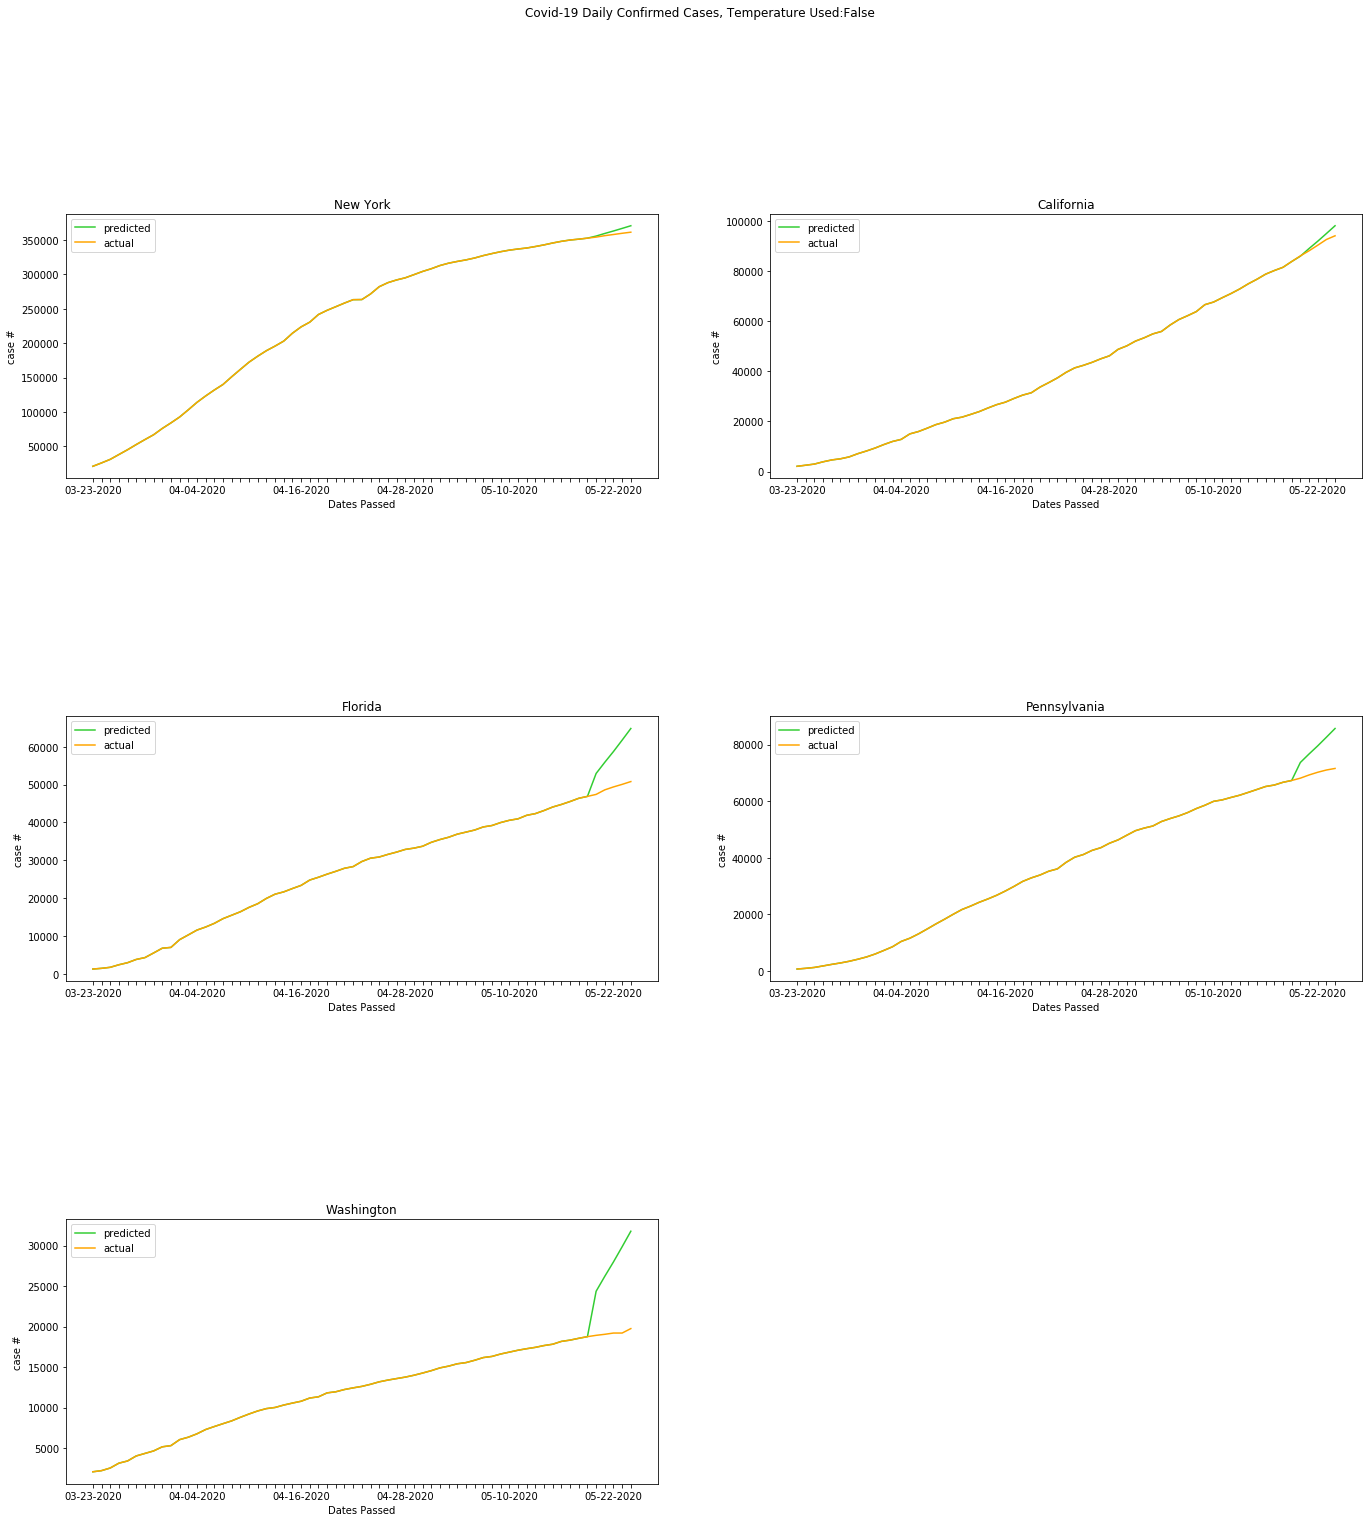

In [7]:
## Draw the Out of Sample Prediction For States
later_task(param)

# GCNN model - Without Temperature - "Deaths" as Response

The model was trained under 500 epochs then stopped. The final testing RMSE is 11.5537. If we continued training, it can futher decreased.

The following figure shows that out of sample prediction for the states. The prediction of all States (NY, CA, FL, PA, WA) are well aligned with true cases, except the WA is a little off.     

In [8]:
param = {
        'use_temperature': False,  
        'learning_rate':0.001, # learning rate
        'decay':0.9,
        'batch_size':8, # batch size 
        'hidden_num_layer':[10, 10, 20], # determine the number of hidden layers and the vector length at each node of each hidden layer
        'reg_weight':[0, 0, 0], # regularization weights for adjacency matrices L1 loss
        'keep':1, # drop out probability
        'early_stop_th':50, # early stopping threshold, if validation RMSE not dropping in continuous 20 steps, break
        'training_epochs':500, # total training epochs
        'score': 'RMSE',
        'response':'Deaths' 
}#

In [4]:
## Train the GCNN Model with Given Parameters
trainer = Trainer(param)  

True
Epoch: 0001 Training RMSE = 272.486214692
Validation RMSE: 398.1517
Epoch: 0006 Training RMSE = 272.042879213
Validation RMSE: 397.5618
Epoch: 0011 Training RMSE = 271.323655614
Validation RMSE: 396.35168
Epoch: 0016 Training RMSE = 269.700284274
Validation RMSE: 393.53134
Epoch: 0021 Training RMSE = 266.264870985
Validation RMSE: 387.75208
Epoch: 0026 Training RMSE = 261.604105536
Validation RMSE: 379.49472
Epoch: 0031 Training RMSE = 255.915954014
Validation RMSE: 369.0431
Epoch: 0036 Training RMSE = 248.458696473
Validation RMSE: 355.61234
Epoch: 0041 Training RMSE = 235.753100989
Validation RMSE: 333.26697
Epoch: 0046 Training RMSE = 203.431351572
Validation RMSE: 278.65796
Epoch: 0051 Training RMSE = 128.815718165
Validation RMSE: 153.53362
Epoch: 0056 Training RMSE = 54.300395606
Validation RMSE: 70.69436
Epoch: 0061 Training RMSE = 37.462006263
Validation RMSE: 40.775368
Epoch: 0066 Training RMSE = 28.188448636
Validation RMSE: 30.923079
Epoch: 0071 Training RMSE = 22.50720

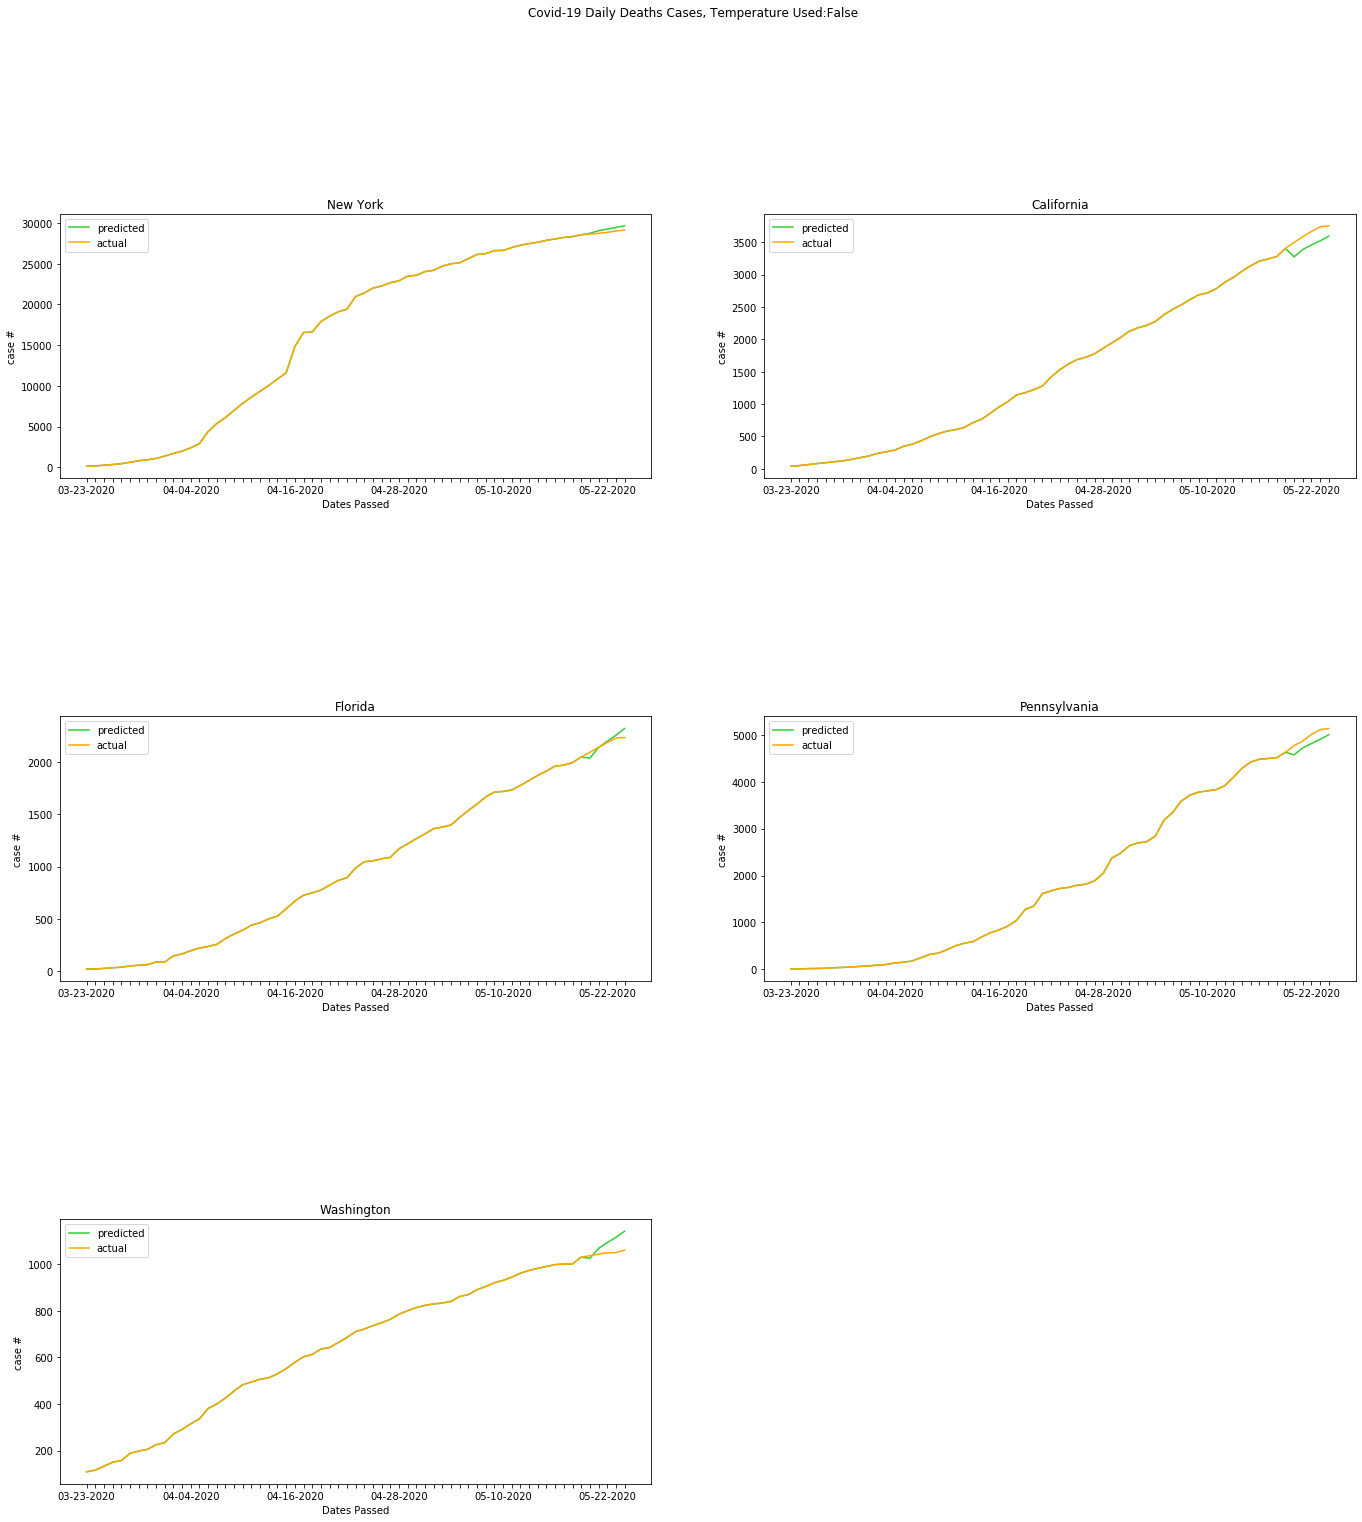

In [9]:
## Draw the Out of Sample Prediction For States
later_task(param)

In [ ]:
if __name__ == "__main__":
    output_dir = ''
    input_dir = ''
    trainer = Trainer(input_dir, output_dir)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0001 Training RMSE = 2645.010564168
Validation RMSE: 4084.8057
Epoch: 0002 Training RMSE = 2581.156392415
Validation RMSE: 4063.9805
Epoch: 0003 Training RMSE = 2560.626937866
Validation RMSE: 4023.269
Epoch: 0004 Training RMSE = 2524.484266917
Validation RMSE: 3948.2368
Epoch: 0005 Training RMSE = 2462.784053802
Validation RMSE: 3818.5347
Epoch: 0006 Training RMSE = 2382.002699534
Validation RMSE: 3656.5076
Epoch: 0007 Training RMSE = 2296.407487233
Validation RMSE: 3504.2727
Epoch: 0008 Training RMSE = 2190.878030141
Validation RMSE: 3303.196
Epoch: 0009 Training RMSE = 2059.168233236
Validation RMSE: 3089.7483
Epoch: 0010 Training RMSE = 1901.711844126
Validation RMSE: 2790.1475
Epoch: 0011 Training RMSE = 1658.522872925
Validation RMSE: 2316.4836
Epoch: 0012 Training RMSE = 1264.380577087
Validation RMSE: 1438.3903
Epoch: 0013 Training RMSE = 691.400260925
Validation RMSE: 519.5498


We also considered the GCNN (Graph Convulutional Neural Netork) + (MLP) or (RNN). We will use it to predict zip code level and daily cov-19 cases. 




- Include Temperatures 
We then cosidered including the climate as addtional features to include the GCNN. We crawled the the US stations daily climate data from the goverment of NOAA climate to the database. We also have two linked data, 1. GHCND stations list with its geogographic (latitude and longitude) information,  2. US Federal Government Zip code with its latitude and longitude. The closeset station $i$ for the $zipcode_{j}$ is givent by $i_{zip_{j}} = argmin_{i}dist(zip_{j} - i)$, where $dist(i,j)$ is the spherical distances. We then searched the 5 most closest stations for each zip code and return the cloeest first avaialbe temperature as the daily temperature for that zip code. In the end, we have around $75%$ zipcode level temperature data coverage. From that, we filled the missing values by it's coleaset zipcode and date wheather data whenever the first non-missing is avaialbe. 

After some backgroud saerch, we thought temperature change is most associated with virius growth other than the precipitation, and drought. Thus we introducted the previous day's maximum and minimum temperature as two additional features into our GCNN model for training.

Adding the temperatures signal heps the learning model faster, we see that under same iteration steps, the models has lower training and validation MSE compared to the basic model. 



